<a href="https://colab.research.google.com/github/LelyshB/Credit_Score/blob/main/Credit_Score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Подготовка среды**

https://drive.google.com/file/d/1FQ4TmNabnfu_o6smvHjyAkoZ1o2qOrUO/view?usp=sharing

In [ ]:
! gdown 1FQ4TmNabnfu_o6smvHjyAkoZ1o2qOrUO

Downloading...
From: https://drive.google.com/uc?id=1FQ4TmNabnfu_o6smvHjyAkoZ1o2qOrUO
To: /content/credit_score.zip
100% 9.97M/9.97M [00:00<00:00, 134MB/s]


In [ ]:
! unzip /content/credit_score.zip

Archive:  /content/credit_score.zip
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
!pip install Catboost

In [ ]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 4.7 MB/s eta 0:00:00


# **Импорты**

In [ ]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt

from catboost import Pool,CatBoostClassifier
from boruta import BorutaPy

from sklearn.preprocessing import StandardScaler,label_binarize,LabelEncoder
from sklearn.impute import KNNImputer

from sklearn.metrics import classification_report,roc_curve, auc, roc_auc_score
from sklearn.model_selection import cross_val_score, train_test_split


from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

import seaborn as sns


from tqdm.notebook import tqdm
import scipy as sp
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle

plt.style.use('dark_background')

# **EDA**

In [ ]:
df = pd.read_csv('/content/train.csv')

<ipython-input-54-337b670ff17c>:1: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/train.csv')


In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

In [ ]:
df.sample(4)

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
19486,0x882c,CUS_0x983a,July,Lynchh,53,866-48-7201,Teacher,74213.52,NaN,5,6,6,0,NaN,19,9,5.65,3.0,Standard,201.35,35.598105,18 Years and 4 Months,No,333.372936,120.17170886315306,High_spent_Large_value_payments,760.374291136847,Good
55578,0x15ba8,CUS_0x93a7,March,Jonathan Cablen,39,#F%$D@*&8,Lawyer,7414.145,903.845417,6,8,26,9,"Not Specified, Mortgage Loan, Auto Loan, Credi...",60,21,17.83,10.0,Bad,2580.05,37.943759,4 Years and 10 Months,Yes,51.416130,81.85332836218804,Low_spent_Small_value_payments,247.11508340290044,Standard
36933,0xee67,CUS_0x7d6e,June,Stephend,19,149-36-7063,Journalist,15508.43,NaN,4,865,16,4,"Home Equity Loan, Home Equity Loan, Student Lo...",16,20,3.07,1.0,Standard,1370.52,30.081751,30 Years and 6 Months,Yes,43.057895,52.11813834072376,Low_spent_Large_value_payments,314.86088375495063,Good
45922,0x12314,CUS_0x1c3b,March,Alexei Anishchukq,39,596-35-8824,_______,79357.14,NaN,2,3,8,4,"Credit-Builder Loan, Payday Loan, Credit-Build...",3,14,2.08,2.0,_,1171.51_,38.073390,17 Years and 11 Months,No,171.998736,113.35559501092126,High_spent_Large_value_payments,624.9551694494834,Standard


**Смотрим на наш таргет**

In [ ]:
df.describe()

,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Delay_from_due_date,Num_Credit_Inquiries,Credit_Utilization_Ratio,Total_EMI_per_month
count,84998.000000,100000.000000,100000.00000,100000.000000,100000.000000,98035.000000,100000.000000,100000.000000
mean,4194.170850,17.091280,22.47443,72.466040,21.068780,27.754251,32.285173,1403.118217
std,3183.686167,117.404834,129.05741,466.422621,14.860104,193.177339,5.116875,8306.041270
min,303.645417,-1.000000,0.00000,1.000000,-5.000000,0.000000,20.000000,0.000000
25%,1625.568229,3.000000,4.00000,8.000000,10.000000,3.000000,28.052567,30.306660
50%,3093.745000,6.000000,5.00000,13.000000,18.000000,6.000000,32.305784,69.249473
75%,5957.448333,7.000000,7.00000,20.000000,28.000000,9.000000,36.496663,161.224249
max,15204.633333,1798.000000,1499.00000,5797.000000,67.000000,2597.000000,50.000000,82331.000000


<Axes: >

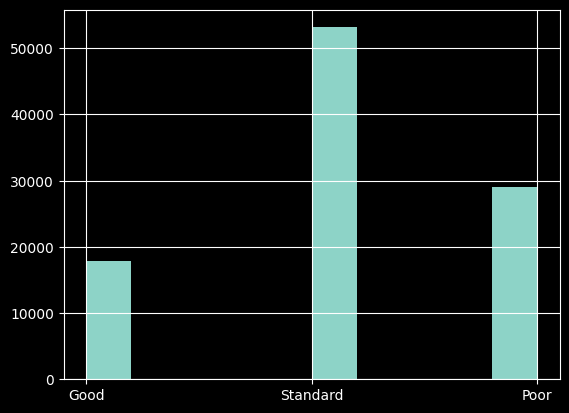

In [ ]:
df['Credit_Score'].hist()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        100000 non-null  object 
 1   Customer_ID               100000 non-null  object 
 2   Month                     100000 non-null  object 
 3   Name                      90015 non-null   object 
 4   Age                       100000 non-null  object 
 5   SSN                       100000 non-null  object 
 6   Occupation                100000 non-null  object 
 7   Annual_Income             100000 non-null  object 
 8   Monthly_Inhand_Salary     84998 non-null   float64
 9   Num_Bank_Accounts         100000 non-null  int64  
 10  Num_Credit_Card           100000 non-null  int64  
 11  Interest_Rate             100000 non-null  int64  
 12  Num_of_Loan               100000 non-null  object 
 13  Type_of_Loan              88592 non-null   ob

In [ ]:
df.isna().sum()

ID                              0
Customer_ID                     0
Month                           0
Name                         9985
Age                             0
SSN                             0
Occupation                      0
Annual_Income                   0
Monthly_Inhand_Salary       15002
Num_Bank_Accounts               0
Num_Credit_Card                 0
Interest_Rate                   0
Num_of_Loan                     0
Type_of_Loan                11408
Delay_from_due_date             0
Num_of_Delayed_Payment       7002
Changed_Credit_Limit            0
Num_Credit_Inquiries         1965
Credit_Mix                      0
Outstanding_Debt                0
Credit_Utilization_Ratio        0
Credit_History_Age           9030
Payment_of_Min_Amount           0
Total_EMI_per_month             0
Amount_invested_monthly      4479
Payment_Behaviour               0
Monthly_Balance              1200
Credit_Score                    0
dtype: int64

 * Видим большое колличество нулевых значений
 * Пропуски не только у числовых значений, но и у текстовых

In [ ]:
df = df.drop(['Name'], axis = 1) # избавляемся от имен для полит. корректности
df = df.drop(['ID'], axis = 1)
df = df.drop(['Customer_ID'], axis = 1)

# **Заполнение пропусков**

* Две необходимые переменные заполним ближайшими соседями
* (По самим значения в колонках видно, что это хороший вариант)

In [ ]:
df['Monthly_Inhand_Salary'].head(20)

0      1824.843333
1              NaN
2              NaN
3              NaN
4      1824.843333
5              NaN
6      1824.843333
7      1824.843333
8      3037.986667
9      3037.986667
10     3037.986667
11             NaN
12     3037.986667
13     3037.986667
14             NaN
15     3037.986667
16    12187.220000
17    12187.220000
18             NaN
19    12187.220000
Name: Monthly_Inhand_Salary, dtype: float64

In [ ]:
imputer = KNNImputer(n_neighbors=2)

monthly_inhand_salary = df['Monthly_Inhand_Salary'].values.reshape(-1, 1)
Num_Credit_Inquiries = df['Num_Credit_Inquiries'].values.reshape(-1, 1)


df['Monthly_Inhand_Salary'] = imputer.fit_transform(monthly_inhand_salary)
df['Num_Credit_Inquiries'] = imputer.fit_transform(Num_Credit_Inquiries)

Далее преобразовываем строковые значения в числовые и заполняем их медианой

In [ ]:
df['Num_of_Delayed_Payment'] = df['Num_of_Delayed_Payment'].astype(str).str.replace(r'[^\d.]+', '', regex=True)
df['Amount_invested_monthly'] = df['Amount_invested_monthly'].astype(str).str.replace(r'[^\d.]+', '', regex=True)
df['Monthly_Balance'] = df['Monthly_Balance'].astype(str).str.replace(r'[^\d.]+', '', regex=True)


df['Num_of_Delayed_Payment'] = pd.to_numeric(df['Num_of_Delayed_Payment'])
df['Amount_invested_monthly'] = pd.to_numeric(df['Amount_invested_monthly'])



median_value = df['Amount_invested_monthly'].median()
df['Amount_invested_monthly'].fillna(median_value, inplace=True)

median_value = df['Num_of_Delayed_Payment'].median()
df['Num_of_Delayed_Payment'].fillna(median_value, inplace=True)

Ниже мы преобразуем строковый тип в дату

In [ ]:
def convert_to_months(period_str):
    if pd.isnull(period_str):
        return None
    parts = period_str.split(' ')
    years = int(parts[0]) if parts[0].isdigit() else 0
    months = int(parts[3]) if len(parts) > 3 and parts[3].isdigit() else 0
    return years * 12 + months

df['Credit_History_Age'] = df['Credit_History_Age'].apply(convert_to_months)

df['Credit_History_Age'].fillna(df['Credit_History_Age'].median(), inplace=True)

In [ ]:
df['Type_of_Loan'].fillna('Not Specified', inplace=True)

Нам не нужно столько знаков перед запятой, поэтому сократим их

In [ ]:
df['Amount_invested_monthly'] = df['Amount_invested_monthly'].round(4)

In [ ]:
df.isna().sum()

Month                       0
Age                         0
SSN                         0
Occupation                  0
Annual_Income               0
Monthly_Inhand_Salary       0
Num_Bank_Accounts           0
Num_Credit_Card             0
Interest_Rate               0
Num_of_Loan                 0
Type_of_Loan                0
Delay_from_due_date         0
Num_of_Delayed_Payment      0
Changed_Credit_Limit        0
Num_Credit_Inquiries        0
Credit_Mix                  0
Outstanding_Debt            0
Credit_Utilization_Ratio    0
Credit_History_Age          0
Payment_of_Min_Amount       0
Total_EMI_per_month         0
Amount_invested_monthly     0
Payment_Behaviour           0
Monthly_Balance             0
Credit_Score                0
dtype: int64

In [ ]:
df.select_dtypes(include='number').columns

Index(['Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card',
       'Interest_Rate', 'Delay_from_due_date', 'Num_of_Delayed_Payment',
       'Num_Credit_Inquiries', 'Credit_Utilization_Ratio',
       'Credit_History_Age', 'Total_EMI_per_month', 'Amount_invested_monthly'],
      dtype='object')

In [ ]:
df.select_dtypes(exclude='number').columns

Index(['Month', 'Age', 'SSN', 'Occupation', 'Annual_Income', 'Num_of_Loan',
       'Type_of_Loan', 'Changed_Credit_Limit', 'Credit_Mix',
       'Outstanding_Debt', 'Payment_of_Min_Amount', 'Payment_Behaviour',
       'Monthly_Balance', 'Credit_Score'],
      dtype='object')

In [ ]:
class_balance = df['Credit_Score'].value_counts(normalize=True)
class_balance

Credit_Score
Standard    0.53174
Poor        0.28998
Good        0.17828
Name: proportion, dtype: float64

# **Обучение** (base line)

In [ ]:
df.sample(4)

,Month,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
17944,January,51,189-34-5628,Developer,19997.78,1409.481667,5,5,20,2,"Not Specified, and Debt Consolidation Loan",28,13.0,4.87,2.0,_,427.06,35.899069,219.0,Yes,18.983797,10000.0000,Low_spent_Small_value_payments,267.7896783265147,Standard
71581,June,45,966-71-9349,Architect,44620.44,3496.370000,0,5,12,2,"Not Specified, and Not Specified",7,11.0,4.57,5.0,Good,286.9,34.428175,318.0,No,50.788305,69.0098,!@9#%8,479.83893128350473,Good
31106,March,42,450-69-9081,Developer,71732.72,6020.726667,4,3,7,3,"Not Specified, Personal Loan, and Student Loan",5,9.0,17.8,4.0,_,632.16,35.550992,78.0,Yes,129.933019,551.2986,Low_spent_Medium_value_payments,200.8410840930591,Standard
9116,May,37,728-13-8219,Lawyer,118111.08,10072.590000,2,6,7,3,"Home Equity Loan, Auto Loan, and Not Specified",27,1.0,4.55,1.0,Good,390.11,28.232590,242.0,No,219.950458,92.8369,High_spent_Large_value_payments,934.4716239897143,Poor


In [ ]:
train, val = train_test_split(df,train_size=0.8,random_state=42)

In [ ]:
X = df.columns.drop('Credit_Score').tolist()

cat_features = df.select_dtypes(exclude='number').columns.drop('Credit_Score').tolist()

y = 'Credit_Score'

In [ ]:
X_train = train[X]
y_train = train[y]
X_val = val[X]
y_val = val[y]

In [ ]:
train_pool = Pool(data=X_train, label=y_train,
                  cat_features=cat_features)

val_pool = Pool(data=X_val, label=y_val,
                cat_features=cat_features)

In [ ]:
model = CatBoostClassifier(
                            iterations=1000,
                            learning_rate=0.01,
                            depth=6,
                            eval_metric='Accuracy',
                            random_seed=42,
                            # task_type='GPU',
                            early_stopping_rounds=50,
                            auto_class_weights='Balanced',
                            verbose=100
)
model.fit(train_pool, eval_set=val_pool, verbose=100)

0:	learn: 0.7806763	test: 0.8361420	best: 0.8361420 (0)	total: 832ms	remaining: 13m 50s
100:	learn: 0.8099758	test: 0.8573660	best: 0.8580610 (80)	total: 1m 9s	remaining: 10m 18s
200:	learn: 0.8135862	test: 0.8616212	best: 0.8617152 (199)	total: 2m 36s	remaining: 10m 23s
300:	learn: 0.8170116	test: 0.8657923	best: 0.8657966 (296)	total: 4m 17s	remaining: 9m 57s
400:	learn: 0.8201905	test: 0.8687393	best: 0.8687393 (400)	total: 6m 5s	remaining: 9m 6s
500:	learn: 0.8219100	test: 0.8713293	best: 0.8713656 (499)	total: 7m 58s	remaining: 7m 56s
600:	learn: 0.8233489	test: 0.8728633	best: 0.8728633 (598)	total: 9m 47s	remaining: 6m 30s
700:	learn: 0.8246837	test: 0.8736752	best: 0.8738311 (695)	total: 11m 46s	remaining: 5m 1s
800:	learn: 0.8255840	test: 0.8743560	best: 0.8743560 (800)	total: 13m 31s	remaining: 3m 21s
900:	learn: 0.8263084	test: 0.8749856	best: 0.8750881 (873)	total: 15m 16s	remaining: 1m 40s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8756008899
bestI

In [ ]:
y_pred_val = model.predict(X_val)

print(classification_report(y_val, y_pred_val))

              precision    recall  f1-score   support

        Good       0.72      0.96      0.82      3527
        Poor       0.76      0.96      0.85      5874
    Standard       0.95      0.71      0.81     10599

    accuracy                           0.82     20000
   macro avg       0.81      0.88      0.83     20000
weighted avg       0.85      0.82      0.82     20000



Также построим ROC-AUC ("один против всех")

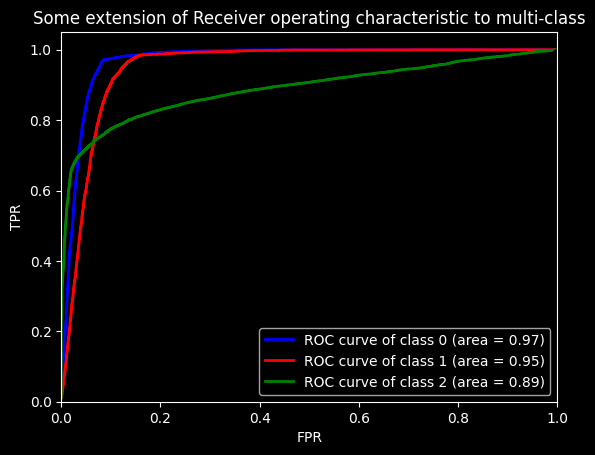

In [ ]:
y_val_binarized = label_binarize(y_val, classes=np.unique(y_val))
n_classes = y_val_binarized.shape[1]

y_score_val = model.predict_proba(X_val)

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val_binarized[:, i], y_score_val[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

colors = ['blue', 'red', 'green', 'purple', 'orange']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

# **Повышаем Score**

* Поиск trash фич
* Тюнинг модели

In [ ]:
feature_importances = model.feature_importances_

feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

random_importance = np.random.rand()
df_random = pd.DataFrame({'Feature': ['Random'], 'Importance': [random_importance]})

feature_importance_df = pd.concat([feature_importance_df, df_random])

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

cm = sns.dark_palette("blue", as_cmap=True)
styled_feature_importance_df = feature_importance_df.style.background_gradient(cmap=cm, subset='Importance')
styled_feature_importance_df

,Feature,Importance
0,Outstanding_Debt,43.625524
1,SSN,9.927148
2,Annual_Income,8.850020
3,Credit_Mix,6.755667
4,Month,5.640419
5,Interest_Rate,4.450541
6,Payment_of_Min_Amount,3.414652
7,Type_of_Loan,2.767753
8,Payment_Behaviour,2.442248
9,Delay_from_due_date,1.788282


In [ ]:
df = df.drop(['Age','Changed_Credit_Limit','Occupation',
              'Num_Bank_Accounts','Num_of_Delayed_Payment',
              'Monthly_Balance','Credit_Utilization_Ratio'], axis = 1)

In [ ]:
train_cleared, val_cleared = train_test_split(df,train_size=0.8,random_state=42)

In [ ]:
X_cleared = df.columns.drop('Credit_Score').tolist()

cat_features = df.select_dtypes(include=['object', 'category']).columns.tolist()

y_cleared = 'Credit_Score'

In [ ]:
if 'Credit_Score' in cat_features:
    cat_features.remove('Credit_Score')

In [ ]:
X_cleared_train = train_cleared[X_cleared]
y_cleared_train = train_cleared[y_cleared]
X_cleared_val = val_cleared[X_cleared]
y_cleared_val = val_cleared[y_cleared]

In [ ]:
train_pool = Pool(data=X_cleared_train, label=y_cleared_train, cat_features=cat_features)
val_pool = Pool(data=X_cleared_val, label=y_cleared_val, cat_features=cat_features)

In [ ]:
model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.01,
    depth=4,
    eval_metric='Accuracy',
    random_seed=42,
    l2_leaf_reg=3,
    early_stopping_rounds=100,
    auto_class_weights='Balanced',
    verbose=100
)

model.fit(train_pool, eval_set=val_pool, verbose=100)


y_pred_val = model.predict(X_cleared_val)
print(classification_report(y_cleared_val, y_pred_val))

0:	learn: 0.6817183	test: 0.6832926	best: 0.6832926 (0)	total: 1.45s	remaining: 24m 10s
100:	learn: 0.7954327	test: 0.8406379	best: 0.8406379 (100)	total: 31.3s	remaining: 4m 38s
200:	learn: 0.8049404	test: 0.8518932	best: 0.8518932 (200)	total: 1m 3s	remaining: 4m 13s
300:	learn: 0.8108054	test: 0.8580618	best: 0.8582512 (290)	total: 1m 41s	remaining: 3m 55s
400:	learn: 0.8135654	test: 0.8605593	best: 0.8605857 (399)	total: 2m 19s	remaining: 3m 28s
500:	learn: 0.8153283	test: 0.8633524	best: 0.8633524 (499)	total: 3m	remaining: 2m 59s
600:	learn: 0.8169559	test: 0.8657786	best: 0.8659154 (588)	total: 3m 41s	remaining: 2m 26s
700:	learn: 0.8185480	test: 0.8673019	best: 0.8674436 (682)	total: 4m 22s	remaining: 1m 52s
800:	learn: 0.8194041	test: 0.8686613	best: 0.8687504 (797)	total: 5m 4s	remaining: 1m 15s
900:	learn: 0.8206504	test: 0.8699204	best: 0.8699204 (900)	total: 5m 46s	remaining: 38.1s
999:	learn: 0.8213923	test: 0.8708577	best: 0.8708890 (994)	total: 6m 27s	remaining: 0us

be

Вывод:
 * Все удаленные признаки никак не повлияли на модель и её score сохранился
 * За счет удаления trash фич, мы добавили в скорости обучения

In [ ]:
model = CatBoostClassifier(
                            iterations=1000,
                            eval_metric='Accuracy',
                            random_seed=42,
                            # task_type='GPU',
                            early_stopping_rounds=50,
                            auto_class_weights='Balanced',
                            verbose=100)

grid = {
    'learning_rate': [0.1, 0,01],
    'depth': [2, 4],
    'l2_leaf_reg': [0.1, 1],
}

grid_search_result = model.grid_search(grid, train_pool, cv=3, partition_random_seed=42, stratified=True, verbose=False, plot=False )


print(grid_search_result['params'])

0:	learn: 0.6315953	test: 0.6322772	best: 0.6322772 (0)	total: 144ms	remaining: 2m 23s
100:	learn: 0.7970577	test: 0.8521234	best: 0.8521234 (100)	total: 17s	remaining: 2m 31s
200:	learn: 0.8026342	test: 0.8594403	best: 0.8596226 (196)	total: 42s	remaining: 2m 46s
300:	learn: 0.8050756	test: 0.8612267	best: 0.8612782 (296)	total: 58.5s	remaining: 2m 15s
400:	learn: 0.8062112	test: 0.8628243	best: 0.8628243 (400)	total: 1m 10s	remaining: 1m 45s
500:	learn: 0.8070730	test: 0.8639745	best: 0.8639745 (494)	total: 1m 22s	remaining: 1m 21s
600:	learn: 0.8075048	test: 0.8640270	best: 0.8642618 (587)	total: 1m 33s	remaining: 1m 1s
700:	learn: 0.8082040	test: 0.8648943	best: 0.8650776 (695)	total: 1m 45s	remaining: 44.9s
800:	learn: 0.8086820	test: 0.8653143	best: 0.8654308 (782)	total: 1m 57s	remaining: 29.3s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8661051041
bestIteration = 848

0:	learn: 0.6315953	test: 0.6322772	best: 0.6322772 (0)	total: 154ms	remaining: 2m 33s


# **Заключение**